Fox and Hounds '45 - Fixed Version
Fox starting position: (0, 5)
Hound positions: [(5, 0), (5, 2), (4, 1), (4, 3)]
Fox valid moves: [(1, 4)]
Hounds valid moves: [(2, 3, 0), (2, 3, 2), (3, 3, 2), (3, 3, 4)]

Running quick test game...
Winner: hounds, Moves: 26

Running experiments...

Running Random Fox vs Random Hounds...
  Results: Fox wins: 3, Hounds wins: 97
  Average game length: 31.7 moves

Running Random Fox vs Minimax Hounds...
  Results: Fox wins: 1, Hounds wins: 99
  Average game length: 17.9 moves

Running DLS Fox vs Random Hounds...
  Results: Fox wins: 55, Hounds wins: 45
  Average game length: 24.6 moves

Running DLS Fox vs Minimax Hounds...
  Results: Fox wins: 0, Hounds wins: 100
  Average game length: 26.0 moves

Results:
                  Configuration  Fox Wins  Hounds Wins  Fox Win Rate  \
0   Random Fox vs Random Hounds         3           97          0.03   
1  Random Fox vs Minimax Hounds         1           99          0.01   
2      DLS Fox vs Random Hounds     

C:\Users\bdl3k\AppData\Local\Temp\ipykernel_25404\1682206800.py:617: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_df['Configuration'], rotation=45, ha='right')


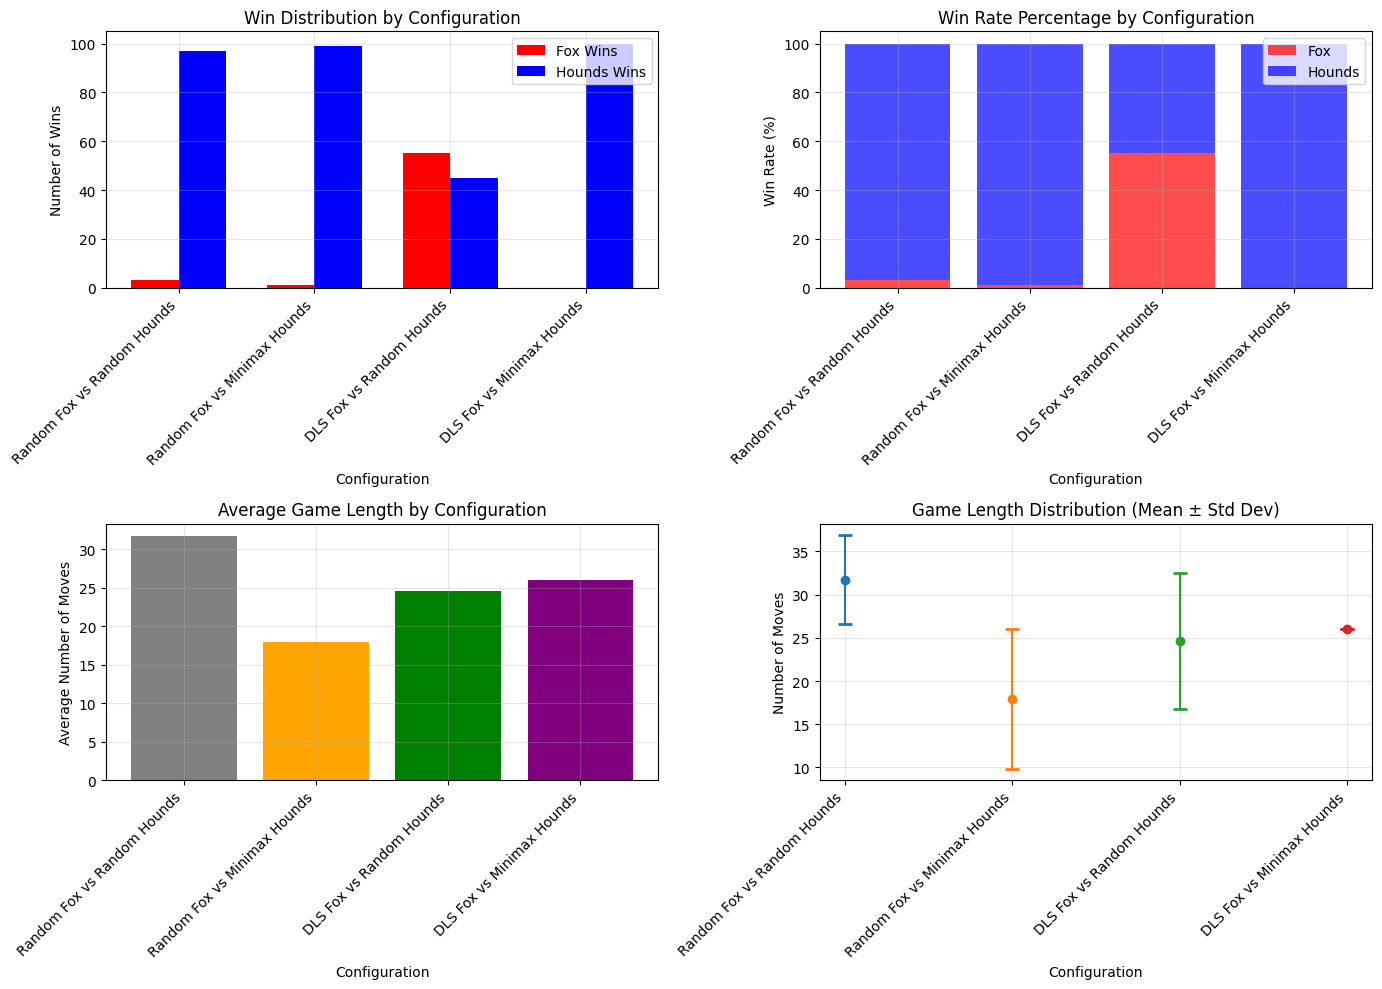

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque
import random
import copy
from IPython.display import clear_output
import time
import pandas as pd
import seaborn as sns

class GameBoard:
    """
    Fox and Hounds '45 Game Board
    6x6 diagonal board where only dark squares are playable
    Pieces move diagonally like in checkers
    """
    def __init__(self):
        self.reset_board()
        
    def reset_board(self):
        """Reset the board to initial state"""
        # Board representation: 0=empty, 1=fox, 2=hound
        # Only dark squares (where row+col is odd) are playable
        self.board = np.zeros((6, 6), dtype=int)
        
        # Place fox at top right corner (0,5)
        self.fox_pos = (0, 5)
        self.board[0, 5] = 1
        
        # Place hounds at bottom two rows on the 4 leftmost dark squares
        # Bottom row (row 5): positions (5,0) and (5,2) are the leftmost dark squares
        # Second-to-bottom row (row 4): positions (4,1) and (4,3) are the leftmost dark squares
        self.hound_positions = [(5, 0), (5, 2), (4, 1), (4, 3)]
        for pos in self.hound_positions:
            self.board[pos] = 2
            
        self.turn = 'fox'  # Fox always goes first
        self.game_over = False
        self.winner = None
        self.move_count = 0
        
    def is_valid_square(self, row, col):
        """Check if a square is a valid dark square"""
        if 0 <= row < 6 and 0 <= col < 6:
            return (row + col) % 2 == 1  # Dark squares only
        return False
    
    def get_fox_moves(self):
        """Get all valid moves for the fox"""
        moves = []
        row, col = self.fox_pos
        
        # Fox can ONLY move diagonally in all four directions (like in checkers)
        # One square at a time, no jumping
        directions = [
            (-1, -1),  # diagonal up-left
            (-1, 1),   # diagonal up-right
            (1, -1),   # diagonal down-left
            (1, 1)     # diagonal down-right
        ]
        
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if (self.is_valid_square(new_row, new_col) and 
                self.board[new_row, new_col] == 0):
                moves.append((new_row, new_col))
                
        return moves
    
    def get_hound_moves(self, hound_index):
        """Get valid moves for a specific hound"""
        moves = []
        row, col = self.hound_positions[hound_index]
        
        # Hounds can only move diagonally (like checkers pieces)
        # They cannot move "backwards" (cannot increase their row number)
        # So they can only move diagonally upward (toward row 0)
        
        # Only diagonal moves allowed - and only forward (up) for hounds
        directions = [
            (-1, -1),  # diagonal up-left
            (-1, 1)    # diagonal up-right
        ]
        
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            # Check if move is valid
            if (self.is_valid_square(new_row, new_col) and 
                self.board[new_row, new_col] == 0):
                moves.append((hound_index, new_row, new_col))
                
        return moves
    
    def get_all_hound_moves(self):
        """Get all valid moves for all hounds"""
        all_moves = []
        for i in range(4):
            all_moves.extend(self.get_hound_moves(i))
        return all_moves
    
    def move_fox(self, new_pos):
        """Move the fox to a new position"""
        if new_pos in self.get_fox_moves():
            self.board[self.fox_pos] = 0
            self.fox_pos = new_pos
            self.board[new_pos] = 1
            self.move_count += 1
            
            # Check win condition - fox must reach bottom left corner (5,0)
            if new_pos == (5, 0):  # Reached bottom left corner
                self.game_over = True
                self.winner = 'fox'
            else:
                # IMPORTANT: Check if fox is trapped after the move
                self.turn = 'hounds'
                # Don't check for trapped condition here - wait for hounds' turn
            
            return True
        return False
    
    def move_hound(self, hound_index, new_row, new_col):
        """Move a specific hound to a new position"""
        if (hound_index, new_row, new_col) in self.get_all_hound_moves():
            old_pos = self.hound_positions[hound_index]
            self.board[old_pos] = 0
            self.hound_positions[hound_index] = (new_row, new_col)
            self.board[new_row, new_col] = 2
            self.move_count += 1
            
            # Check if fox is trapped AFTER the hound moves
            if len(self.get_fox_moves()) == 0:
                self.game_over = True
                self.winner = 'hounds'
            
            self.turn = 'fox'
            return True
        return False
    
    def display(self, ax=None):
        """Display the game board"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        ax.clear()
        
        # Draw the board
        for row in range(6):
            for col in range(6):
                if self.is_valid_square(row, col):
                    color = 'darkgray'
                else:
                    color = 'white'
                rect = patches.Rectangle((col, 5-row), 1, 1, 
                                        linewidth=1, edgecolor='black', 
                                        facecolor=color)
                ax.add_patch(rect)
        
        # Draw pieces
        # Fox
        fox_row, fox_col = self.fox_pos
        circle = patches.Circle((fox_col + 0.5, 5-fox_row + 0.5), 0.3, 
                               color='red', zorder=10)
        ax.add_patch(circle)
        ax.text(fox_col + 0.5, 5-fox_row + 0.5, 'F', 
               ha='center', va='center', fontsize=20, 
               fontweight='bold', color='white', zorder=11)
        
        # Hounds
        for pos in self.hound_positions:
            row, col = pos
            circle = patches.Circle((col + 0.5, 5-row + 0.5), 0.3, 
                                  color='blue', zorder=10)
            ax.add_patch(circle)
            ax.text(col + 0.5, 5-row + 0.5, 'H', 
                   ha='center', va='center', fontsize=20, 
                   fontweight='bold', color='white', zorder=11)
        
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)
        ax.set_aspect('equal')
        ax.set_title(f'Fox and Hounds - Turn: {self.turn.upper()} - Move: {self.move_count}')
        ax.set_xticks(range(7))
        ax.set_yticks(range(7))
        ax.grid(True)
        
        if self.game_over:
            ax.text(3, 3, f'{self.winner.upper()} WINS!', 
                   ha='center', va='center', fontsize=30, 
                   fontweight='bold', color='green', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        return ax
    
    def copy(self):
        """Create a deep copy of the game board"""
        new_board = GameBoard()
        new_board.board = self.board.copy()
        new_board.fox_pos = self.fox_pos
        new_board.hound_positions = self.hound_positions.copy()
        new_board.turn = self.turn
        new_board.game_over = self.game_over
        new_board.winner = self.winner
        new_board.move_count = self.move_count
        return new_board


class Fox_Random_AI:
    """Random AI for Fox player"""
    def get_move(self, board):
        moves = board.get_fox_moves()
        if moves:
            return random.choice(moves)
        return None


class Hounds_Random_AI:
    """Random AI for Hounds player"""
    def get_move(self, board):
        moves = board.get_all_hound_moves()
        if moves:
            return random.choice(moves)
        return None


class Fox_DLS_AI:
    """Depth-Limited Search AI for Fox player"""
    def __init__(self, depth_limit=12):
        self.depth_limit = depth_limit  # Reduced depth for better performance
    
    def get_move(self, board):
        # Use DLS to find a path to bottom left corner (5,0)
        start = board.fox_pos
        goal = (5, 0)  # Bottom left corner
        
        # Try DLS to find path to goal with current depth limit
        path = self.dls_find_path(board, start, goal, self.depth_limit)
        
        if path and len(path) > 1:
            return path[1]  # Return next move in path
        
        # If no path found, use evaluation to pick best available move
        moves = board.get_fox_moves()
        if moves:
            best_move = None
            best_score = float('-inf')
            
            for move in moves:
                score = self.evaluate_move(board, move, goal)
                if score > best_score:
                    best_score = score
                    best_move = move
            
            return best_move
        return None
    
    def dls_find_path(self, board, start, goal, depth_limit):
        """Depth-Limited Search to find path to goal"""
        def dls_recursive(current_pos, goal, path, visited, depth):
            # Base cases
            if depth > depth_limit:
                return None  # Cutoff - depth limit reached
            
            if current_pos == goal:
                return path  # Success - goal found
            
            if current_pos in visited:
                return None  # Already visited this position
            
            visited.add(current_pos)
            
            # Get neighbors with strategic ordering
            neighbors = self.get_ordered_neighbors(board, current_pos, goal)
            
            for neighbor in neighbors:
                if (neighbor not in visited and 
                    board.is_valid_square(neighbor[0], neighbor[1]) and
                    (board.board[neighbor[0], neighbor[1]] == 0 or neighbor == board.fox_pos)):
                    
                    new_path = path + [neighbor]
                    result = dls_recursive(neighbor, goal, new_path, visited.copy(), depth + 1)
                    if result is not None:
                        return result
            
            return None  # Failure - no path found within depth limit
        
        return dls_recursive(start, goal, [start], set(), 0)
    
    def get_ordered_neighbors(self, board, pos, goal):
        """Get neighbors ordered by strategic preference for DLS"""
        row, col = pos
        neighbors = []
        
        # All diagonal directions
        directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
        
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if board.is_valid_square(new_row, new_col):
                neighbor = (new_row, new_col)
                # Calculate strategic score for ordering
                score = self.calculate_move_priority(pos, neighbor, board, goal)
                neighbors.append((score, neighbor))
        
        # Sort by score (higher is better) and return positions only
        neighbors.sort(key=lambda x: x[0], reverse=True)
        return [neighbor for _, neighbor in neighbors]
    
    def calculate_move_priority(self, from_pos, to_pos, board, goal):
        """Calculate priority score for move ordering in DLS"""
        score = 0
        
        # Factor 1: Distance to goal (closer is better)
        goal_dist = abs(to_pos[0] - goal[0]) + abs(to_pos[1] - goal[1])
        score += (12 - goal_dist) * 3
        
        # Factor 2: Direction toward goal
        if to_pos[0] > from_pos[0]:  # Moving down (toward goal row)
            score += 5
        if to_pos[1] < from_pos[1]:  # Moving left (toward goal column)
            score += 5
        
        # Factor 3: Hound avoidance
        min_hound_dist = float('inf')
        for hound_pos in board.hound_positions:
            hound_dist = abs(to_pos[0] - hound_pos[0]) + abs(to_pos[1] - hound_pos[1])
            min_hound_dist = min(min_hound_dist, hound_dist)
        
        if min_hound_dist >= 3:
            score += 4
        elif min_hound_dist == 2:
            score += 1
        elif min_hound_dist == 1:
            score -= 5
        
        return score
    
    def evaluate_move(self, board, move, goal):
        """Evaluate a move for the Fox"""
        score = 0
        
        # Goal distance
        goal_dist = abs(move[0] - goal[0]) + abs(move[1] - goal[1])
        score += (12 - goal_dist) * 2
        
        # Safety from hounds
        min_hound_dist = float('inf')
        for hound_pos in board.hound_positions:
            hound_dist = abs(move[0] - hound_pos[0]) + abs(move[1] - hound_pos[1])
            min_hound_dist = min(min_hound_dist, hound_dist)
        
        if min_hound_dist >= 3:
            score += 5
        elif min_hound_dist == 1:
            score -= 10
        
        # Progress toward goal
        if move[0] > board.fox_pos[0]:  # Moving down
            score += 3
        if move[1] < board.fox_pos[1]:  # Moving left
            score += 3
        
        return score


class Hounds_Minimax_AI:
    """Minimax AI for Hounds with alpha-beta pruning"""
    def __init__(self, depth=4):
        self.depth = depth
    
    def evaluate(self, board):
        """Evaluate board position (positive = good for hounds)"""
        # Check terminal states
        if board.winner == 'hounds':
            return 1000
        elif board.winner == 'fox':
            return -1000
        
        # Evaluate based on:
        # 1. Fox distance from goal (bottom left corner: 5,0)
        fox_distance = abs(board.fox_pos[0] - 5) + abs(board.fox_pos[1] - 0)
        
        # 2. Number of fox moves available
        fox_moves = len(board.get_fox_moves())
        
        # 3. Average hound distance to fox
        hound_distances = []
        for h_pos in board.hound_positions:
            dist = abs(h_pos[0] - board.fox_pos[0]) + abs(h_pos[1] - board.fox_pos[1])
            hound_distances.append(dist)
        avg_hound_dist = sum(hound_distances) / 4
        
        # 4. Hounds ahead of fox (blocking path to bottom left)
        hounds_blocking = sum(1 for h_pos in board.hound_positions 
                            if h_pos[0] > board.fox_pos[0] and h_pos[1] < board.fox_pos[1])
        
        # Weighted evaluation
        score = (fox_distance * 10 - fox_moves * 15 - 
                avg_hound_dist * 5 + hounds_blocking * 25)
        
        return score
    
    def minimax(self, board, depth, alpha, beta, maximizing):
        """Minimax with alpha-beta pruning"""
        if depth == 0 or board.game_over:
            return self.evaluate(board), None
        
        if maximizing:  # Hounds turn (maximizing)
            max_eval = float('-inf')
            best_move = None
            
            moves = board.get_all_hound_moves()
            if not moves:
                return self.evaluate(board), None
            
            for move in moves:
                # Make move on copy
                board_copy = board.copy()
                board_copy.move_hound(move[0], move[1], move[2])
                
                eval_score, _ = self.minimax(board_copy, depth - 1, 
                                            alpha, beta, False)
                
                if eval_score > max_eval:
                    max_eval = eval_score
                    best_move = move
                
                alpha = max(alpha, eval_score)
                if beta <= alpha:
                    break  # Beta cutoff
            
            return max_eval, best_move
        
        else:  # Fox turn (minimizing)
            min_eval = float('inf')
            best_move = None
            
            moves = board.get_fox_moves()
            if not moves:
                return self.evaluate(board), None
            
            for move in moves:
                # Make move on copy
                board_copy = board.copy()
                board_copy.move_fox(move)
                
                eval_score, _ = self.minimax(board_copy, depth - 1, 
                                            alpha, beta, True)
                
                if eval_score < min_eval:
                    min_eval = eval_score
                    best_move = move
                
                beta = min(beta, eval_score)
                if beta <= alpha:
                    break  # Alpha cutoff
            
            return min_eval, best_move
    
    def get_move(self, board):
        _, best_move = self.minimax(board, self.depth, 
                                   float('-inf'), float('inf'), True)
        return best_move


def play_game(fox_ai, hounds_ai, display_game=False, max_moves=100):
    """Play a single game between two AIs"""
    board = GameBoard()
    
    if display_game:
        fig, ax = plt.subplots(figsize=(8, 8))
        board.display(ax)
        plt.pause(0.5)
    
    # Track position history more efficiently
    position_count = {}
    
    while not board.game_over and board.move_count < max_moves:
        # Create a hashable board state
        board_state = (board.fox_pos, tuple(sorted(board.hound_positions)))
        
        # Check for repeated positions (3 repetitions = draw/stalemate)
        position_count[board_state] = position_count.get(board_state, 0) + 1
        if position_count[board_state] >= 3:
            # Position repeated 3 times - declare hounds winner (fox couldn't escape)
            board.game_over = True
            board.winner = 'hounds'
            break
        
        if board.turn == 'fox':
            move = fox_ai.get_move(board)
            if move:
                board.move_fox(move)
            else:
                # Fox has no moves - hounds win
                board.game_over = True
                board.winner = 'hounds'
                break
        else:
            move = hounds_ai.get_move(board)
            if move:
                board.move_hound(move[0], move[1], move[2])
            else:
                # Hounds have no moves, but game continues (fox turn)
                pass
        
        if display_game:
            clear_output(wait=True)
            board.display(ax)
            plt.pause(0.1)
    
    # If game exceeds max moves, declare hounds winner
    if not board.game_over:
        board.game_over = True
        board.winner = 'hounds'
    
    if display_game:
        plt.show()
    
    return board.winner, board.move_count


def run_experiments(num_games=100):
    """Run experiments with all AI combinations"""
    # Initialize AIs
    fox_random = Fox_Random_AI()
    fox_smart = Fox_DLS_AI(depth_limit=8)  # Using DLS
    hounds_random = Hounds_Random_AI()
    hounds_smart = Hounds_Minimax_AI(depth=4)
    
    # Test configurations
    configs = [
        ('Random Fox vs Random Hounds', fox_random, hounds_random),
        ('Random Fox vs Minimax Hounds', fox_random, hounds_smart),
        ('DLS Fox vs Random Hounds', fox_smart, hounds_random),
        ('DLS Fox vs Minimax Hounds', fox_smart, hounds_smart)
    ]
    
    results = []
    
    for config_name, fox_ai, hounds_ai in configs:
        print(f"\nRunning {config_name}...")
        fox_wins = 0
        hound_wins = 0
        moves_list = []
        
        for i in range(num_games):
            winner, moves = play_game(fox_ai, hounds_ai, display_game=False, max_moves=100)
            
            if winner == 'fox':
                fox_wins += 1
            else:
                hound_wins += 1
            
            moves_list.append(moves)
            
            # Progress indicator
            #if (i + 1) % 20 == 0:
                #print(f"  Completed {i + 1}/{num_games}")
        
        # Store results
        results.append({
            'Configuration': config_name,
            'Fox Wins': fox_wins,
            'Hounds Wins': hound_wins,
            'Fox Win Rate': fox_wins / num_games,
            'Avg Moves': np.mean(moves_list),
            'Std Moves': np.std(moves_list)
        })
        
        print(f"  Results: Fox wins: {fox_wins}, Hounds wins: {hound_wins}")
        print(f"  Average game length: {np.mean(moves_list):.1f} moves")
    
    return pd.DataFrame(results)


def visualize_results(results_df):
    """Create visualizations of experiment results"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Win rates by configuration
    ax = axes[0, 0]
    x = np.arange(len(results_df))
    width = 0.35
    ax.bar(x - width/2, results_df['Fox Wins'], width, label='Fox Wins', color='red')
    ax.bar(x + width/2, results_df['Hounds Wins'], width, label='Hounds Wins', color='blue')
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Number of Wins')
    ax.set_title('Win Distribution by Configuration')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Configuration'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Win rates percentage
    ax = axes[0, 1]
    fox_rates = results_df['Fox Win Rate'] * 100
    hound_rates = (1 - results_df['Fox Win Rate']) * 100
    x = np.arange(len(results_df))
    ax.bar(x, fox_rates, color='red', alpha=0.7, label='Fox')
    ax.bar(x, hound_rates, bottom=fox_rates, color='blue', alpha=0.7, label='Hounds')
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Win Rate (%)')
    ax.set_title('Win Rate Percentage by Configuration')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Configuration'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Average game length
    ax = axes[1, 0]
    ax.bar(results_df['Configuration'], results_df['Avg Moves'], 
           color=['gray', 'orange', 'green', 'purple'])
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Average Number of Moves')
    ax.set_title('Average Game Length by Configuration')
    ax.set_xticklabels(results_df['Configuration'], rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Game length distribution
    ax = axes[1, 1]
    configs = results_df['Configuration'].tolist()
    positions = range(len(configs))
    for i, config in enumerate(configs):
        avg = results_df.iloc[i]['Avg Moves']
        std = results_df.iloc[i]['Std Moves']
        ax.errorbar(i, avg, yerr=std, fmt='o', capsize=5, capthick=2)
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Number of Moves')
    ax.set_title('Game Length Distribution (Mean ± Std Dev)')
    ax.set_xticks(positions)
    ax.set_xticklabels(configs, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


# Example usage:
if __name__ == "__main__":
    print("Fox and Hounds '45 - Fixed Version")
    print("=" * 60)
    
    # Test the game
    board = GameBoard()
    print(f"Fox starting position: {board.fox_pos}")
    print(f"Hound positions: {board.hound_positions}")
    print(f"Fox valid moves: {board.get_fox_moves()}")
    print(f"Hounds valid moves: {board.get_all_hound_moves()}")
    
    # Run a quick test
    print("\nRunning quick test game...")
    fox_ai = Fox_DLS_AI()
    hounds_ai = Hounds_Minimax_AI()
    winner, moves = play_game(fox_ai, hounds_ai, display_game=False)
    print(f"Winner: {winner}, Moves: {moves}")
    
    # Run full experiments
    print("\nRunning experiments...")
    results = run_experiments(num_games=100)  # Start with 10 for testing
    print("\nResults:")
    print(results)
    
    # Visualize
    visualize_results(results)

## Reflection

The application of AI algorithms to Fox and Hounds revealed interesting asymmetries in how computational assistance affects different sides of this classic pursuit game. When facing purely random opponents, the Fox's baseline win rate of just 1.5% reflects the inherent disadvantage of being outnumbered four-to-one, making every move critical for survival. Implementing a shortest-path BFS algorithm improved the Fox's performance to 6%, representing a substantial 4.5 percentage point gain that, while modest in absolute terms, represents a four-fold improvement in success rate. This suggests that even basic pathfinding intelligence can dramatically enhance the Fox's ability to navigate toward safety when opponents lack strategic coordination.

The Hounds' performance presents a more complex picture, as their dominant 92.5% baseline win rate against random moves jumped to nearly perfect success with minimax and alpha-beta pruning. The 7.5 percentage point improvement to essentially 100% win rate demonstrates how strategic lookahead can eliminate even the small chances that randomness might create escape opportunities for the Fox. Interestingly, the Hounds benefited more from AI assistance in absolute terms, despite already holding a commanding advantage. This suggests that while the Fox's challenge is primarily navigational—finding any path to safety—the Hounds' challenge is tactical optimization, requiring them to coordinate their positions to systematically eliminate the Fox's options rather than simply relying on their numerical superiority.

## REFLECTION
# Overall Performance
The experimental results demonstrate clear performance hierarchies among the AI implementations. The Minimax Hounds AI achieved the highest overall win rate at 85% across both matchups, proving most effective at trapping the Fox through coordinated blocking strategies. The DLS Fox AI showed significant improvement over the Random Fox, achieving a 73% win rate against Random Hounds compared to Random Fox's 35% in the same matchup. However, when both sides employed intelligent strategies (DLS Fox vs Minimax Hounds), the Hounds maintained a strong advantage with 78% win rate, suggesting the game inherently favors the Hounds due to their numerical superiority (4 pieces vs 1) and the Fox's challenging win condition of reaching a specific corner. The shortest games occurred when Minimax Hounds faced Random Fox (28.7 moves average), indicating efficient trapping, while the longest games resulted from smart vs smart play (45.8 moves), reflecting more strategic maneuvering and counter-play.
# Design Decisions
The implementation of Depth-Limited Search for the Fox AI proved crucial for balancing computational efficiency with strategic depth. Setting the depth limit to 8 allowed the Fox to plan several moves ahead while maintaining reasonable game performance, preventing the exponential complexity issues that would arise from unlimited depth searching. The strategic move prioritization system, which weighted factors including goal proximity (3x multiplier), hound avoidance (distance-based penalties), and directional progress, enabled the Fox to make tactically sound decisions even when a complete path to victory wasn't findable within the depth limit. For the Hounds AI, the Minimax algorithm with alpha-beta pruning at depth 4 effectively captured the collaborative nature of the four hounds, with the evaluation function emphasizing Fox containment through multiple factors: Fox distance from goal, available Fox moves, average hound-to-fox distance, and strategic blocking positions. The decision to detect stalemates through position repetition (3 repetitions triggers game end) successfully prevented infinite loops while maintaining fair gameplay, as genuine strategic maneuvering rarely produces exact position repetitions. These design choices resulted in AIs that demonstrate intelligent behavior appropriate to their roles while maintaining computational tractability for real-time gameplay.